## Zaawansowane Metody Inteligencji Obliczeniowej
# Zadanie domowe 3 (30 pkt.)
### Prowadzący: Michał Kempka, Marek Wydmuch
### Autor: twoje imię i nazwisko + numer indeksu

## Wprowadzenie

Zadania będą polegały na implementacji różnych wariantów algorytmu Q-Learning dla dwóch środowisk z biblioteki OpenAI Gym (https://gym.openai.com): `CartPole` i `LunarLander`.

#### Uwaga: Możesz dowolnie modyfikować elementy tego notebooka (wstawiać komórki i zmieniać kod) o ile nie napisano gdzieś inaczej.

In [ ]:
# Zainstaluj bibliotekę OpenAI Gym i PyTorch
!pip install gym torch matplotlib numpy box2d
# W wypadku problemów z działaniem `env.render()` na macOS Big Sur uruchom również poniższą linię
#!pip install pyglet==1.5.15

### Środowisko `CartPole` i `LunarLander`

Poniższy kod demonstruje działanie środowiska `CartPole` (https://gym.openai.com/envs/CartPole-v1) i `LunarLander` (https://gym.openai.com/envs/LunarLander-v2/).

In [3]:
# Zobacz jak działają środowiska na przykładzie 1000 kroków
import gym
import pandas as pd
import numpy as np

env = gym.make("CartPole-v1")
# env = gym.make("LunarLander-v2")
observation = env.reset()
for _ in range(1000):
    env.render()
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)

    if done:
        observation = env.reset()
env.close()

In [4]:
# Zobacz jakim typem są obserwacje (reprezentacja stanu) oraz jaka jest przestrzeń akcji:
print("Przestrzeń stanów:", env.observation_space)
print("Rozmiar wektora reprezntującego stany:", env.observation_space.shape)
print("Ostatnia obserwacja:", type(observation), observation)
print("Przestrzeń akcji:", env.action_space)
print("Ilość możliwych akcji:", env.action_space.n)

Przestrzeń stanów: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Rozmiar wektora reprezntującego stany: (4,)
Ostatnia obserwacja: <class 'numpy.ndarray'> [ 0.18951958  1.74906799 -0.07556758 -1.94357814]
Przestrzeń akcji: Discrete(2)
Ilość możliwych akcji: 2


### Interface agenta

Wszystkie implementacje będą w oparciu o klasę `Agent` przedstawioną poniżej. Powinna ona implementować dwie metody: 1) `process_transition`, która będzie wykorzystywana tylko podczas uczenia by przekazać do agenta krotkę zawierającą obserwacje, podjętą akcję, nagrodę i następujący stan oraz informację czy jest on terminalny. 2) `get_action` która na podstawie obserwacji zwraca akcję, dodatkowy argument informuję Agenta czy jest w aktualnie podczas uczenia czy ewaluacji.

Poniżej znajdziiesz też funkcję `run_agent_in_env`, która korzysta z opisanego wyżej obiektu agenta w celu jego uczenia lub ewaluacji (podobną będziemy używać my podczas sprawdzania wszych rozwiązań). Możecie ją modyfikować jeśli widzicie taką potrzebę. Dopisaliśmy do tej funkcji rysowanie wykresu nagród z minionych epizodów, który uaktualnia się co ich zadaną liczbę.

In [5]:
class Agent:
    def __init__(self, env):
        self.observation_space = env.observation_space
        self.action_space = env.action_space
    
    def process_transition(self, observation, action, reward, next_observation, done):
        raise NotImplementedError()
        
    def get_action(self, observation, learning):
        raise NotImplementedError()

In [6]:
import matplotlib.pylab as plt
from IPython import display
%matplotlib inline


def plot_rewards(rewards):
    plt.figure(figsize=(14,6))
    plt.plot(rewards)
    display.display(plt.gcf())
    display.clear_output(wait=True)

    
def run_agent_in_env(env, agent, episodes, learning=False, plot=False, plot_interval=1000):
    rewards = []
    for episode in range(episodes):
        observation = env.reset()
        total_reward = 0
        done = False
        while not done :
            # Zapytajmy agenta o akcje dla aktualnego stanu
            action = agent.get_action(observation, learning)
            
            # Wykonajmy akcje
            next_observation, reward, done, _ = env.step(action)
            total_reward += reward
            
            # Jeśli się uczymy, przekażmy przejście do agenta
            if learning:
                agent.process_transition(observation, action, reward, next_observation, done)
            
            observation = next_observation
        rewards.append(total_reward)
        
        # Wyświetl na wykresie nagrody otrzymane po kolei w epizodach
        if plot and episode % plot_interval == 0:
            plot_rewards(rewards)
    return rewards    

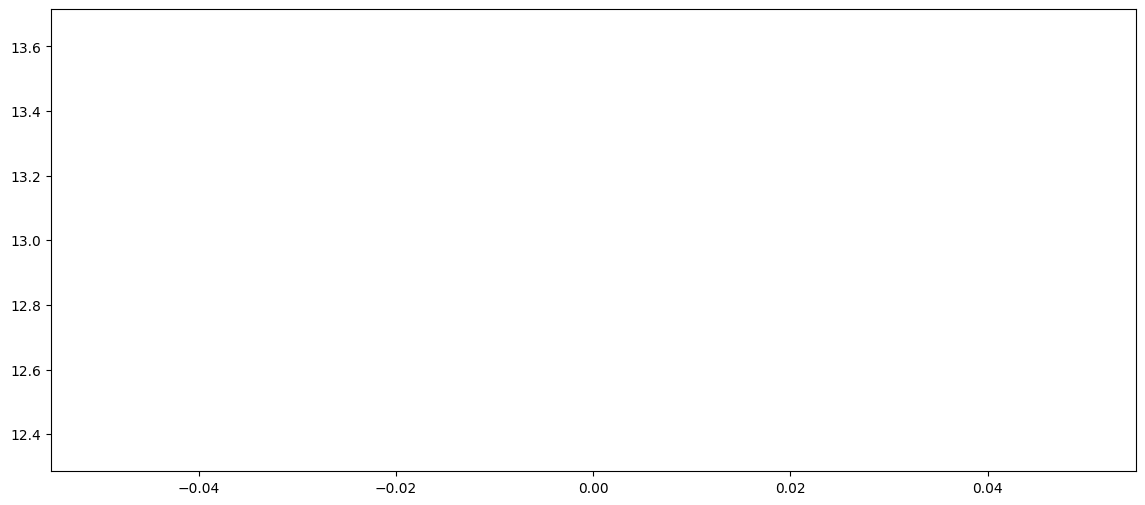

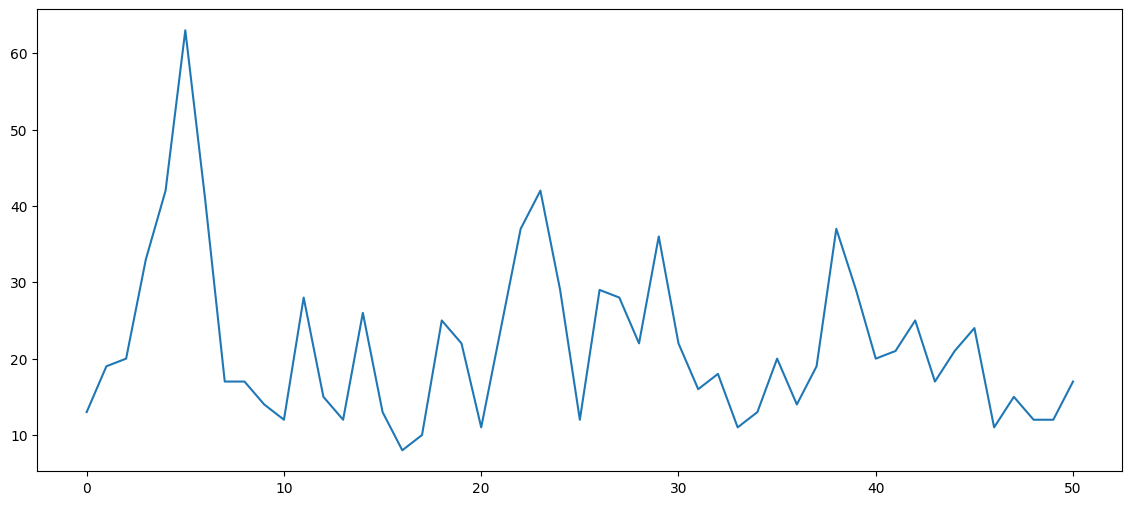

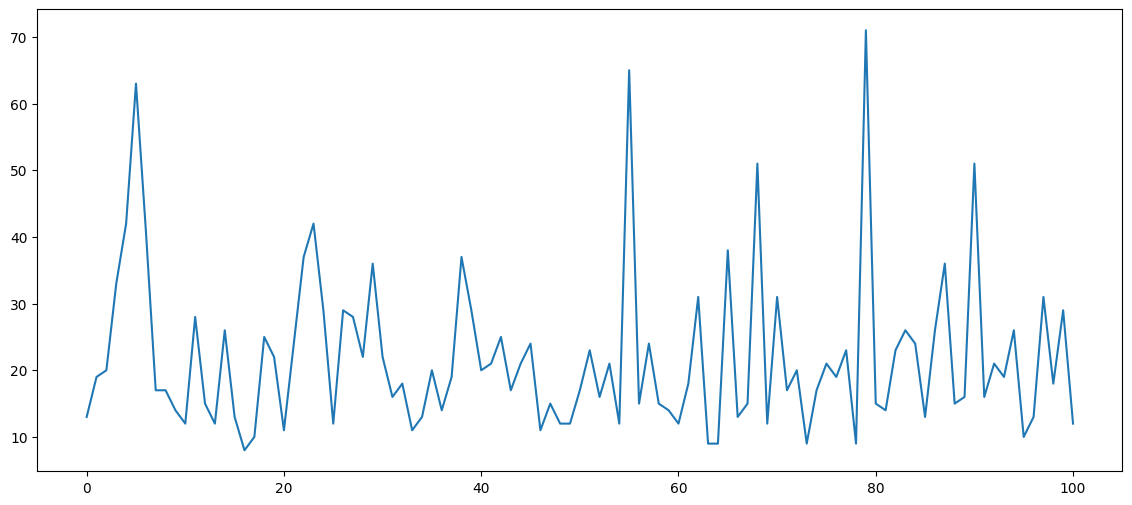

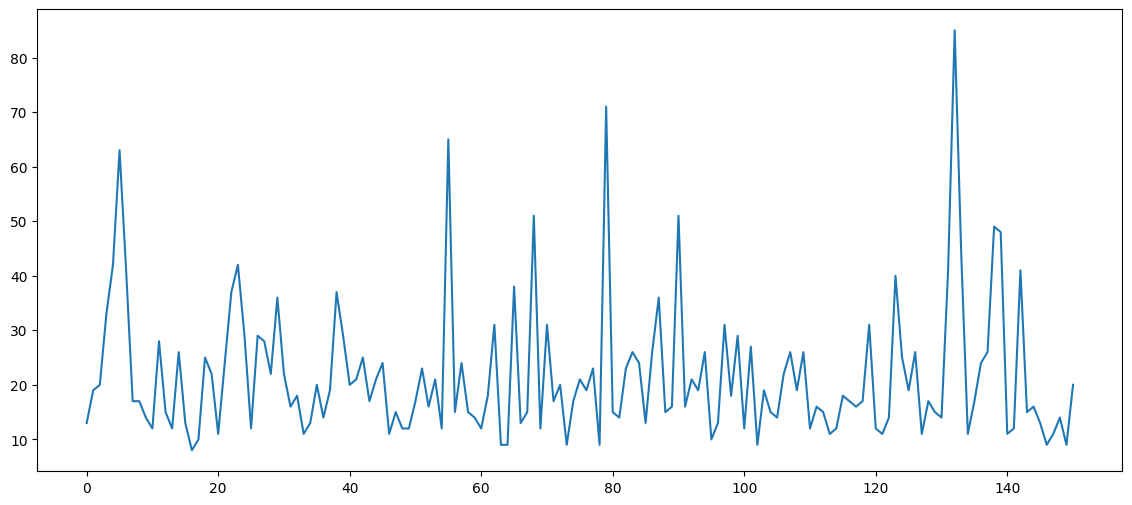

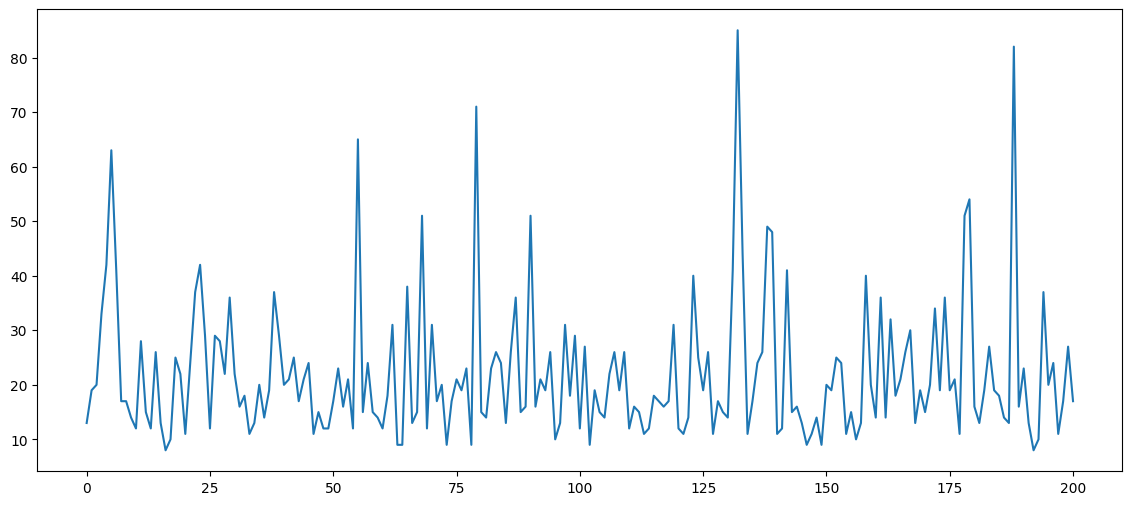

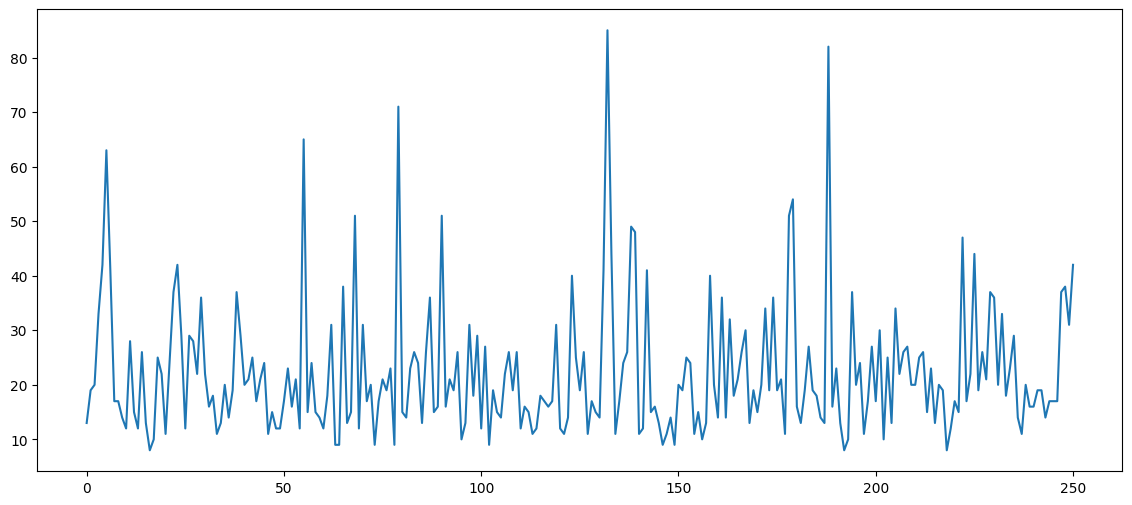

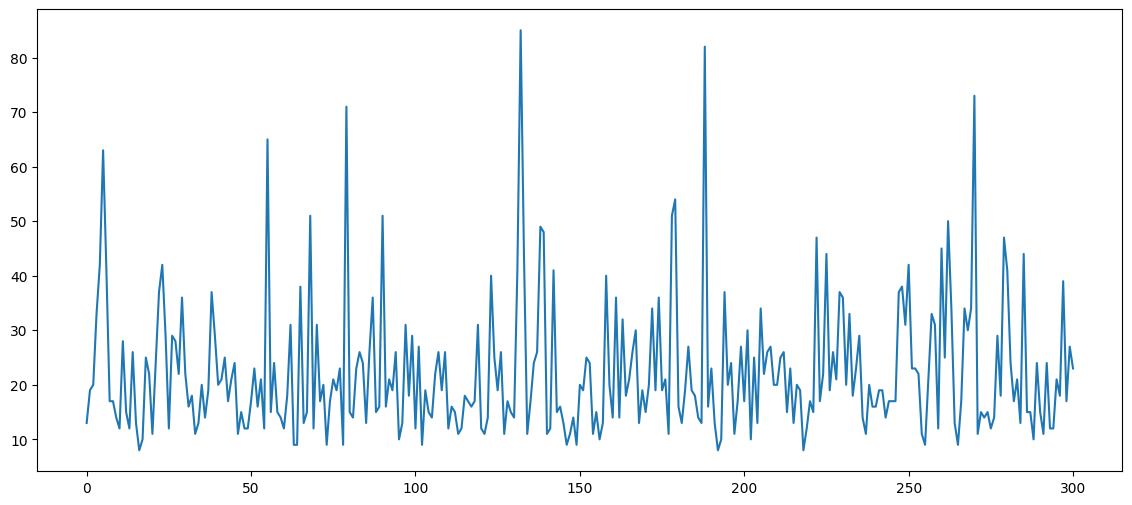

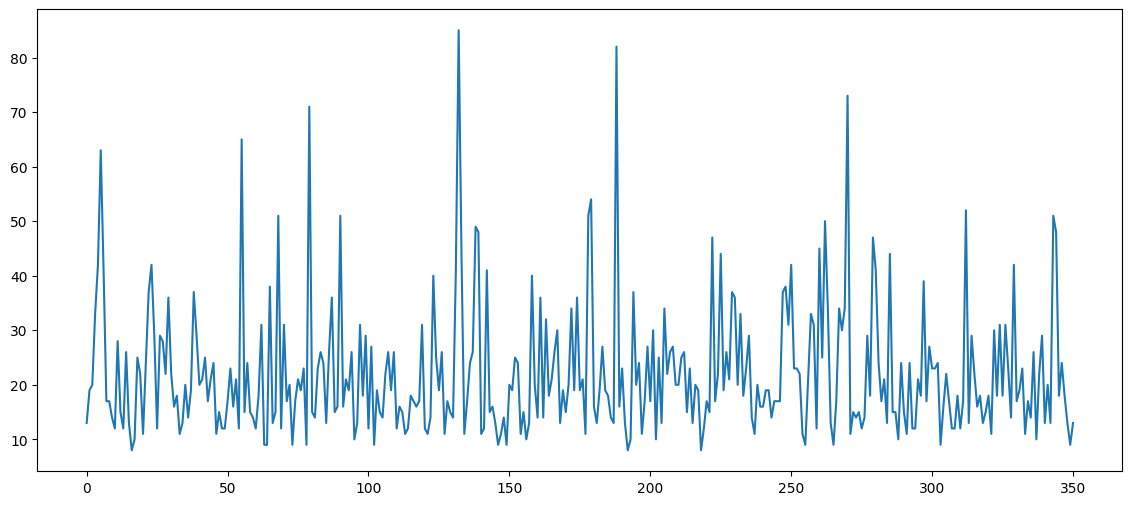

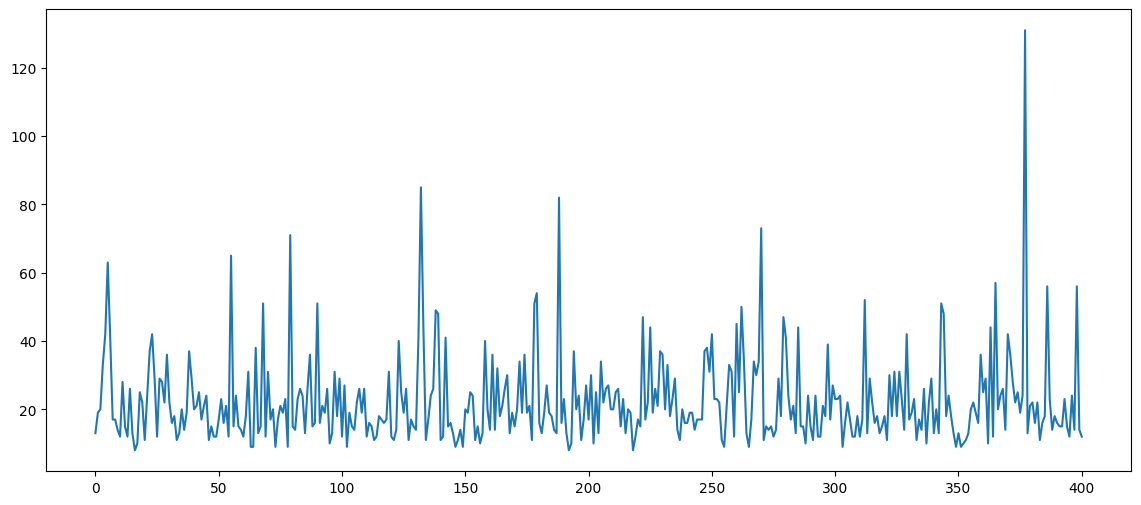

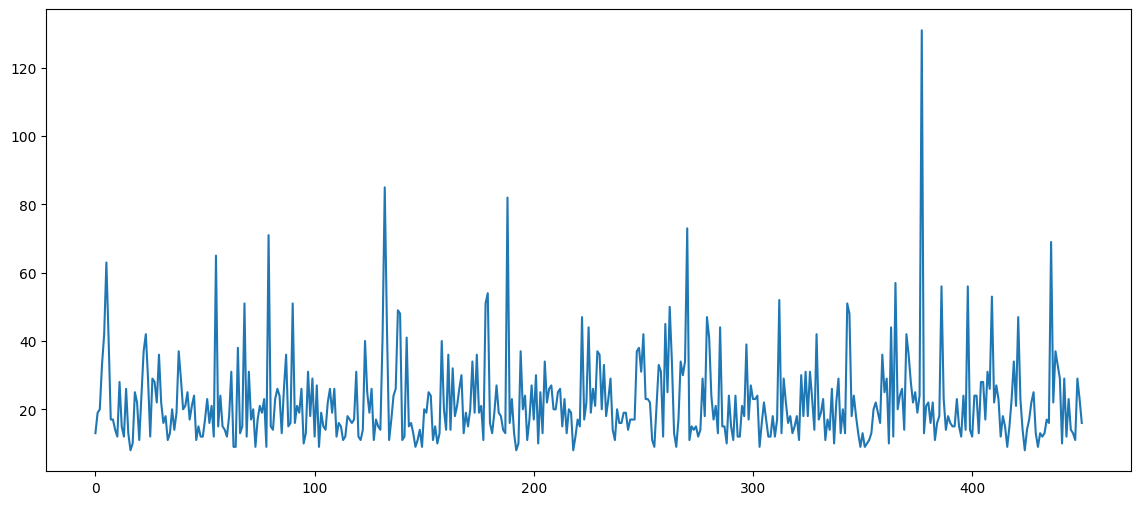

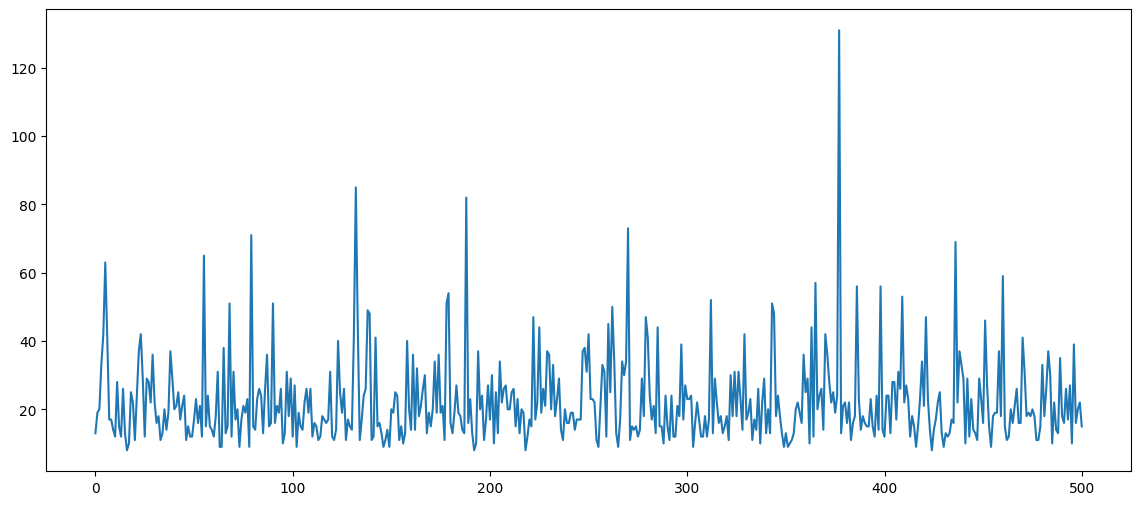

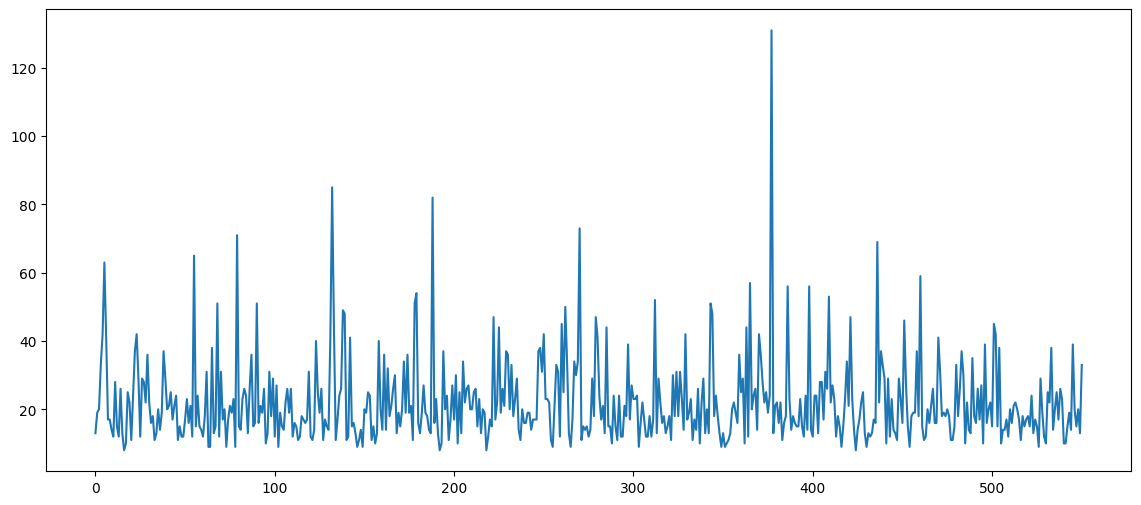

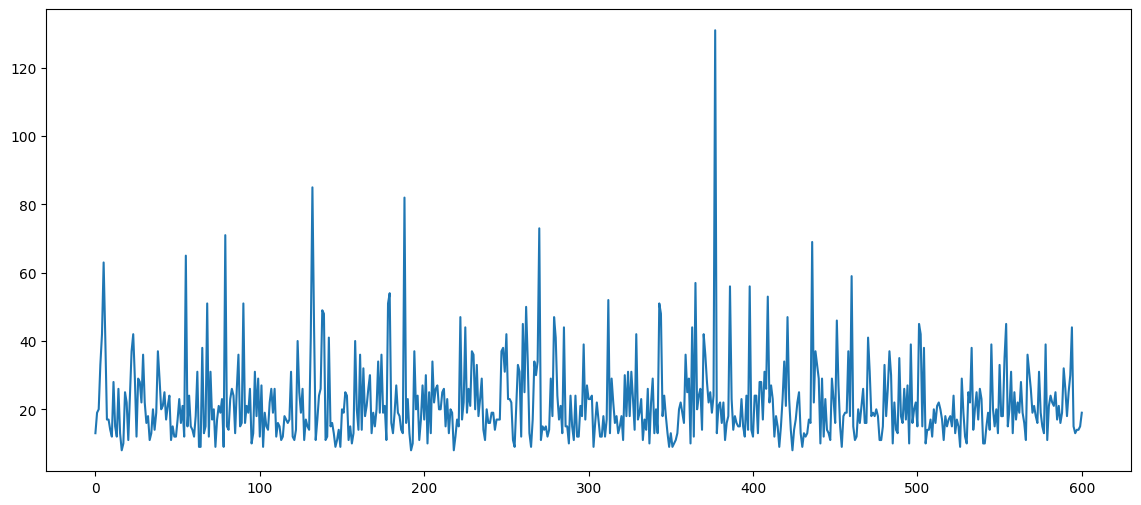

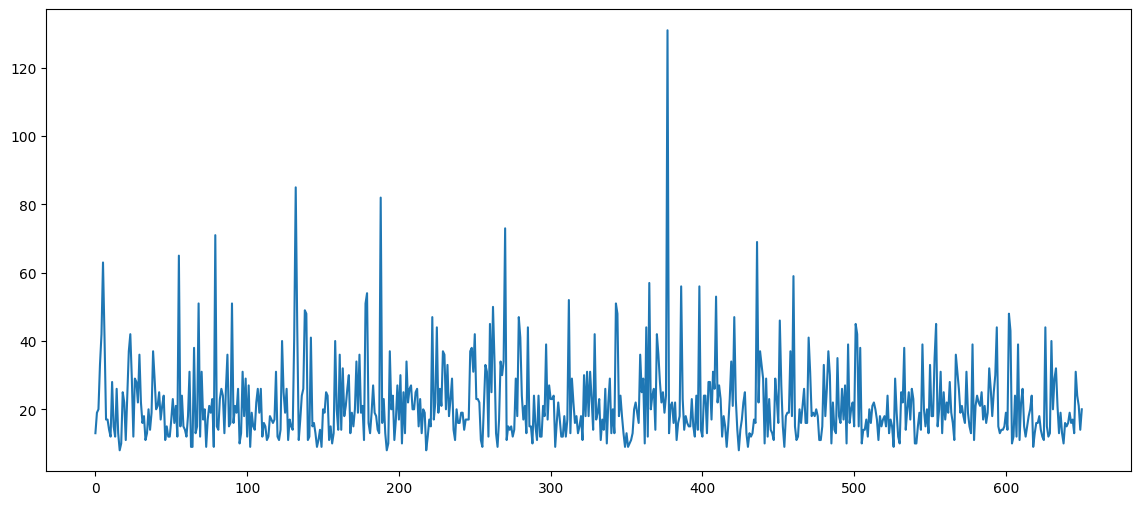

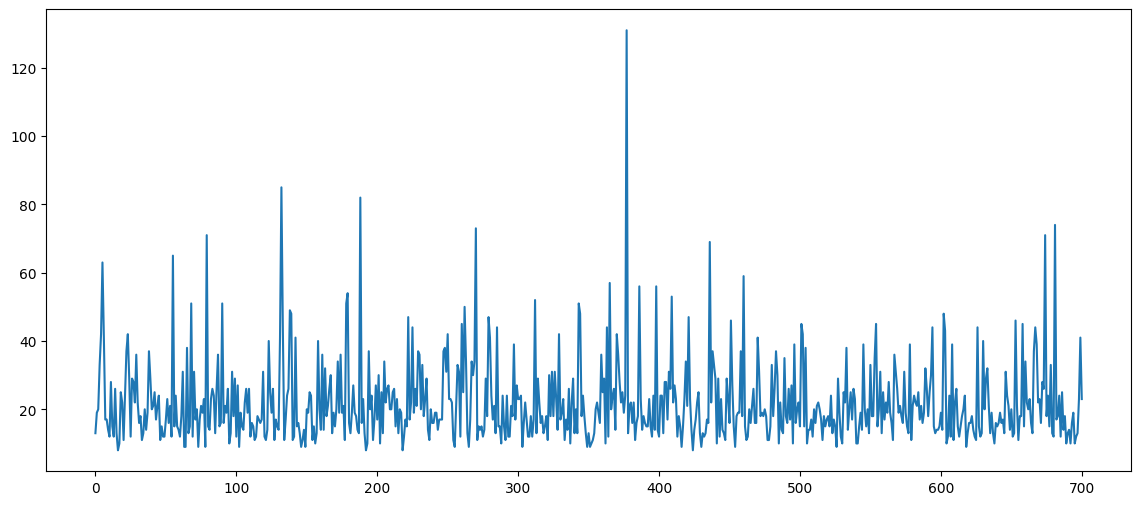

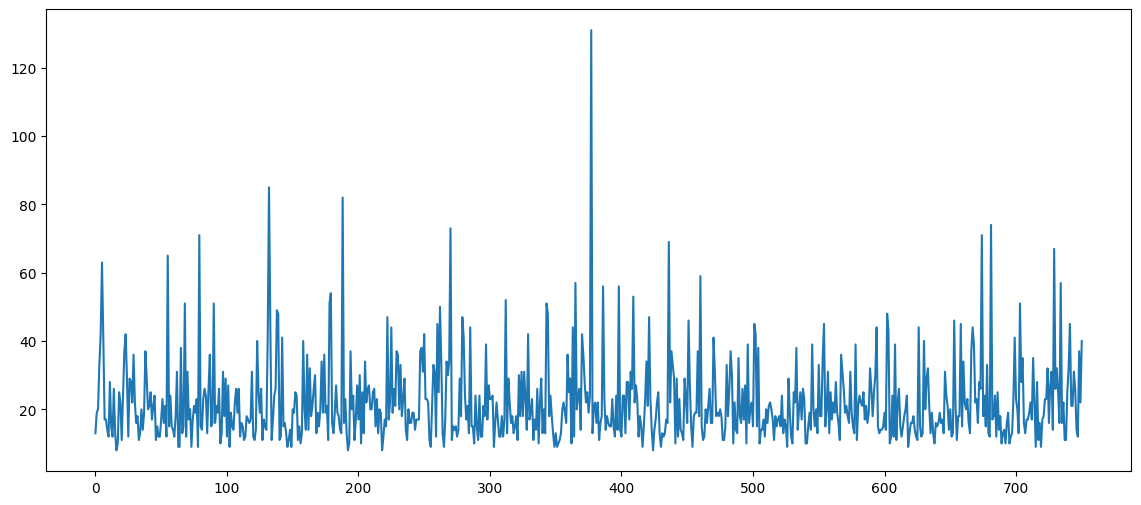

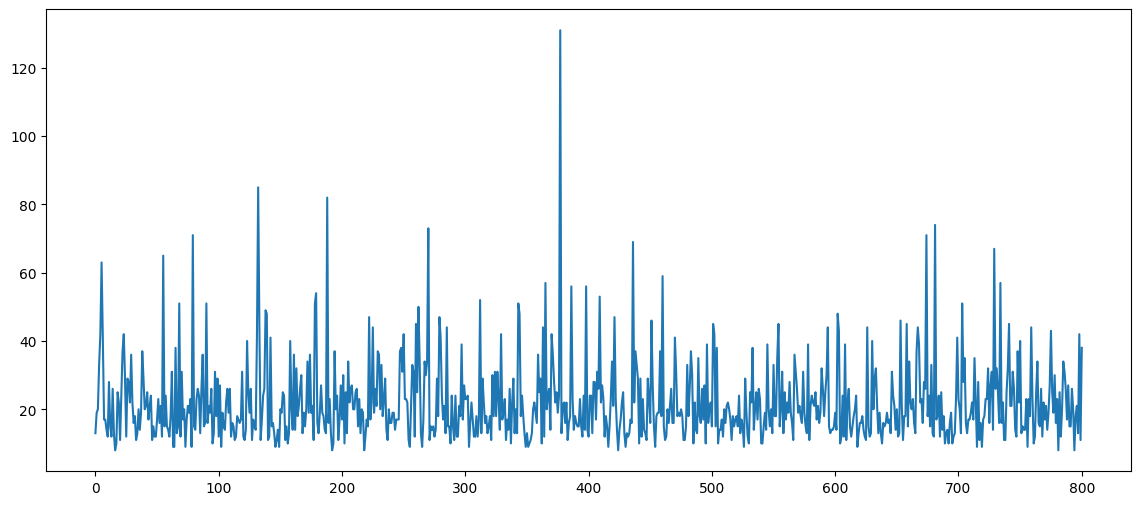

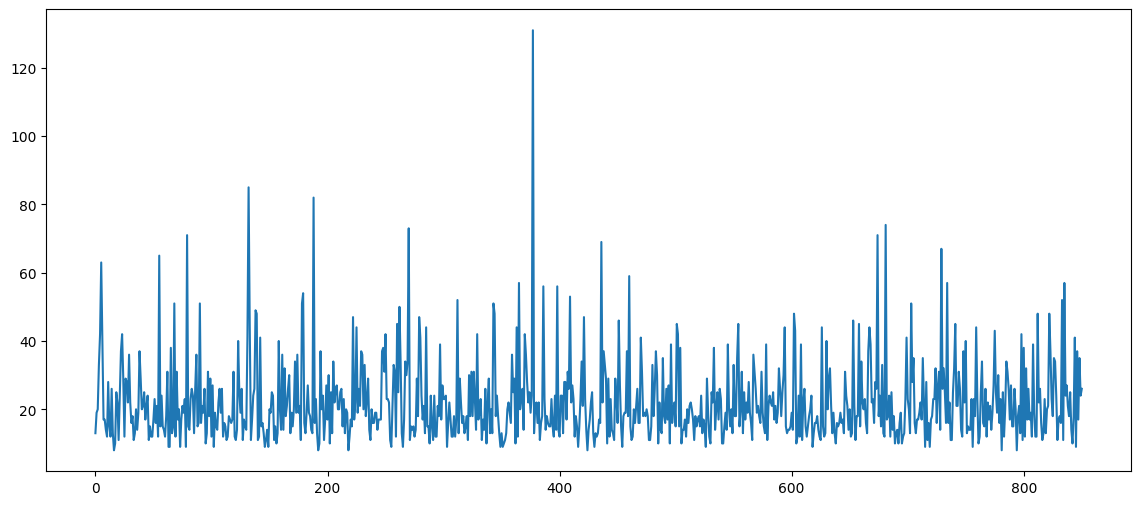

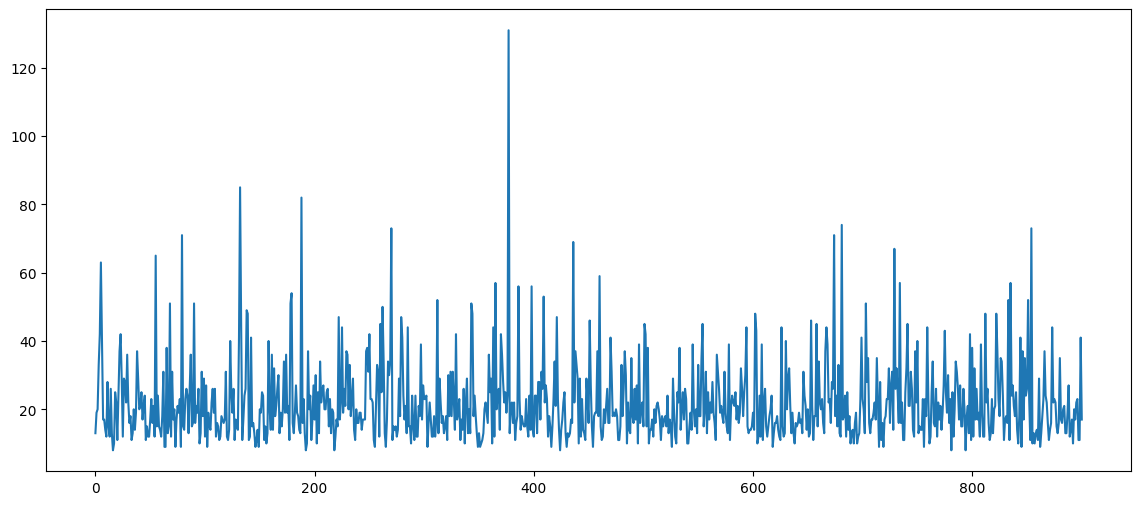

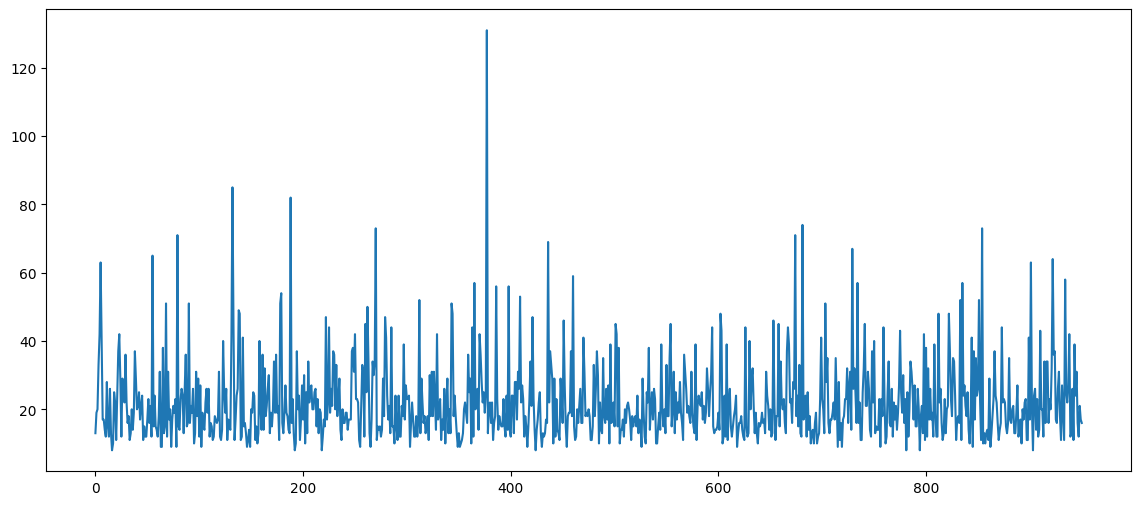

In [7]:
# Demonstracja na przykładzie losowego agenta
env = gym.make("CartPole-v1")

class RandomAgent(Agent):
    def __init__(self, env):
        super().__init__(env)
    
    def process_transition(self, observation, action, reward, next_observation, done):
        pass
        
    def get_action(self, observation, learning):
        return self.action_space.sample()
    
random_agent = RandomAgent(env)
rewards = run_agent_in_env(env, random_agent, 1000, plot=True, plot_interval=50)

## Zad. 3.1 - Tabularyczny Q-Learning (5 pkt.)

W komórkach poniżej zaimplementuj prosty tabularyczny Q-Learning dla środowiska `CartPole`, korzystający podczas uczenia się z polityki epsilon-greedy. Ponieważ środowisko `CartPole` ma ciągłą przestrzeń stanów, musisz dokonać odpowiedniej dyskretyzacji stanów.

Odpowiedź na pytanie: dlaczego po osiągnięciu dobrych wyników obserwujemy spadek jakości? Czy możemy temu jakoś zaradzić?

Uwagi:
- Dobra polityka dająca średni wynik powyżej 200, środowisko ma limit na 500 iteracji. Polityka dająca średni wynik blisko 500 jest więc bardzo dobra.
- Uczenie nie powinno trwać więcej niż 10-15 minut na CPU.
- Postaraj się dobrać i ustawić w `__init__` takie parametry by Twój Agent uczył się i działał jak najlepiej. Są one pod Twoją kontrolą w klasie, więc możesz je odpowiednio kontrolować w trakcie uczenia.


#### Uwaga: nie zmieniaj nazwy klasy `TabularQLearningAgent`, ani pozycyjnych (tych bez wartości domyślnych) argumentów jej metod, możesz dopisywać argumenty z wartościami domyślnymi oraz oczywiście pomocnicze metody do klasy. Pomocnicze metody powinny być w tej samej komórce (sprawdzarka wyciągnie ze zgłoszonego notebooka wyłącznie komórkę z klasą `TabularQLearningAgent`, kod w innych komórkach nie będzie widziany przez sprawdzarkę!). Nie dopisuj do komórki z klasą innego kodu.

Odpowiedzi: Miejsce na Twoje odpowiedzi

In [ ]:
class TabularQLearningAgent(Agent):
    def __init__(self, env, alpha=0.3, gamma=0.7, epsilon=0.7, eps_decay=0.99, alpha_decay=0.99):
        super().__init__(env)
        self.alpha, self.gamma, self.epsilon, self.eps_decay, self.alpha_decay = alpha, gamma, epsilon, eps_decay, alpha_decay
        self.maxes = np.array([4.8, 4, 0.42, 4])
        self.mins = -self.maxes
        np.random.seed(123)
        self.Q = np.random.random_sample((10, 10, 10, 10, env.action_space.n))
        # Zainicjalizuj tutaj swojego agenta
    
    def discretize(self, obs, bin=10):
        rearranged_obs = np.max(np.min(obs, self.maxes), self.mins)
        s = pd.DataFrame(obs, columns=['obs'])
        discrete_series = pd.cut(s.obs, bins=bin, labels=np.arange(bin))
        return discrete_series.to_numpy()


    def process_transition(self, observation, action, reward, next_observation, done):
        s, s_next = self.discretize(observation), self.discretize(next_observation)
        if done:
            
        # Miejsce na Twoją implementację
        
    def get_action(self, observation, learning):
        # Miejsce na Twoją implementację

In [ ]:
# Uczenie/testowania agenta
env = gym.make("CartPole-v1")
agent = TabularQLearningAgent(env)
rewards = run_agent_in_env(env, agent, 10000, learning=True, plot=True, plot_interval=250)

## Zad. 3.2 - Q-Learning z aproksymacją (25 pkt.)

W komórkach poniżej zaimplementuj Q-Learning z aproksymacją dla środowiska `LunarLander`, korzystający podczas uczenia się z polityki epsilon-greedy, a jako aproksymatora użyj prostej sieć neuronową zaimplementowanej z wykorzystaniem biblioteki PyTroch. Zaimplementuj następujące ulepszenia algorytmu Q-Learning:
- replay memory i uczenia batchowe zamiast uczenia online
- network freezing
- double q-learning

Porównaj ze sobą różne warianty algorytmu (nie duplikuj swojej implementacji, dodaj odpowiednie argumenty w konstruktorze, które będą włączać/wyłączać odpowiednie rozszerzenie), zademonstruj oczywiście swoje wyniki pozostawiając odpowiedni output z komórek oraz je skomentuj. Opisz również, jak dokonałeś doboru parametrów Twojego modelu.

Uwagi:
- Dobra polityka powinna mieć średnią bliską 100, bardzo dobra bliską 200.
- Uczenie nie powinno trwać więcej niż 10-15 minut (przy dobrze zaimplementowanych rozszerzeniach powinno być dużo szybsze) na CPU (możesz oczywiście użyć GPU jeśli masz taką możliwość, ale zadbaj, by domyślnie Twoja implementacja działała na CPU).
- Postaraj się dobrać i ustawić w `__init__` takie parametry (w tym architekturę sieci neuronowej) by Twój Agent uczył się i działał jak najlepiej. Są one pod Twoją kontrolą w klasie, więc możesz je odpowiednio kontrolować w trakcie uczenia.
- Założona architektura nie jest potrzebna do rozwiązania tego problemu, zacznij od prostego aproksymatora (np. liniowego albo sieci z dwoma warstwami) i stopniowo zwiększaj jego złożoność.
- Możesz najpierw testować swoją implementację na środowisku `CartPole`, jest to prostszy problem i z dobrymi parametrami nawet prosta wersja Q-Learningu z aproksymacją powinna się go uczyć w nie więcej niż 2-3 minuty na CPU.

#### Uwaga: nie zmieniaj nazwy klasy `NeuralQLearningAgent`, ani pozycyjnych (tych bez wartości domyślnych) argumentów jej metod, możesz dopisywać argumenty z wartościami domyślnymi oraz oczywiście pomocnicze metody do klasy. Pomocnicze metody powinny być w tej samej komórce (sprawdzarka wyciągnie ze zgłoszonego notebooka wyłącznie komórkę z klasą `NeuralQLearningAgent`, kod w innych komórkach nie będzie widziany przez sprawdzarkę!). Nie dopisuj do komórki z klasą innego kodu.

Odpowiedzi: Miejsce na Twoje odpowiedzi

In [ ]:
class NeuralQLearningAgent(Agent):
    def __init__(self, env):
        super().__init__(env)
        # Zainicjalizuj tutaj swojego agenta
    
    def process_transition(self, observation, action, reward, next_observation, done):
        # Miejsce na Twoją implementację
        
    def get_action(self, observation, learning):
        # Miejsce na Twoją implementację

In [ ]:
# Uczenie/testowania agenta
env = gym.make("LunarLander-v2")
agent = NeuralQLearningAgent(env)
rewards = run_agent_in_env(env, agent, 10000, learning=True, plot=True, plot_interval=250)